In [1]:
main_dir = './'
data_dir = '/home/tunx404/Miscellaneous/data/' # Local Jupyter

GOOGLE_COLAB = False

"""Detectron2 heads

ObjectDetection
SemanticSegmentation
InstanceSegmentation
PanopticSegmentation
"""

from detectron2_predictor import Detectron2Predictor

from utilities import create_file_list, imshow_jupyter
import carla_converter

import os

import cv2
import matplotlib.pyplot as plt
from PIL import Image

import torch
import numpy as np

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
if GOOGLE_COLAB:
    from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.engine import DefaultTrainer, hooks
from detectron2.evaluation import SemSegEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [2]:
data_carla_dir = data_dir + 'Carla/'

# Dir structure:
# <data_carla_dir>
#     packages2
#     packages3
#     ...

def get_carla_file_list(data_dir, packages=[], levels=[]):
    file_list = []
    
    for package in packages:
        temp_file_name_list, temp_file_path_list = create_file_list(data_dir, package)
        
        for i in range(len(temp_file_name_list)):
            file_name_split = temp_file_name_list[i].split('_')
            if len(file_name_split) == 3: # [id, type, level.png]
                file_id = file_name_split[0]
                level = file_name_split[2].replace('.png', '')
                if level in levels:
                    file_list.append((file_id, level, package))
                    
    print(f'Number of images: {len(file_list)}')
    
    return file_list

data_carla_train_file_list = get_carla_file_list(data_carla_dir, packages=['package2', 'package4'], levels=['H', 'M', 'S'])
data_carla_val_file_list = get_carla_file_list(data_carla_dir, packages=['package3'], levels=['H', 'M', 'S'])

def get_carla_dicts(file_list, data_dir):
    dicts = []
    
    for file in file_list:
        file_id, level, package = file

        image_clear_path = os.path.join(data_dir, package, file_id + '_clear.png')
        image_rain_path = os.path.join(data_dir, package, file_id + '_rain_' + level + '.png')
        image_semantic_path = os.path.join(data_dir, package, file_id + '_semantic_single.png')

        record = {}
        record['file_name'] = image_rain_path
        record['height'] = 720 # image_rain.shape[0]
        record['width'] = 1280 # image_rain.shape[1]
        record['image_id'] = file_id
        record['sem_seg_file_name'] = image_semantic_path
        
        dicts.append(record)

    return dicts

def get_carla_train_dicts():
    return get_carla_dicts(data_carla_train_file_list, data_carla_dir)

def get_carla_val_dicts():
    return get_carla_dicts(data_carla_val_file_list, data_carla_dir)

Number of images: 11
Number of images: 31


In [3]:
# def convert_carla(file_list, data_dir):
#     for file in file_list:
#         file_id, level, package = file
#         image_semantic_path = os.path.join(data_dir, package, file_id + '_semantic.png')
#         image_semantic = cv2.imread(image_semantic_path)[:, :, 2] # HxWxC, BGR
#         # print(image_semantic)
#         # imshow_jupyter(image_semantic)
#         output_file_name = os.path.join(data_dir, package, file_id + '_semantic_single.png')
#         # print(output_file_name)
#         # cv2.imwrite(output_file_name, image_semantic)

# convert_carla(data_carla_train_file_list, data_carla_dir)

# Semantic Segmentation

# Carla images

Number of classes: 23


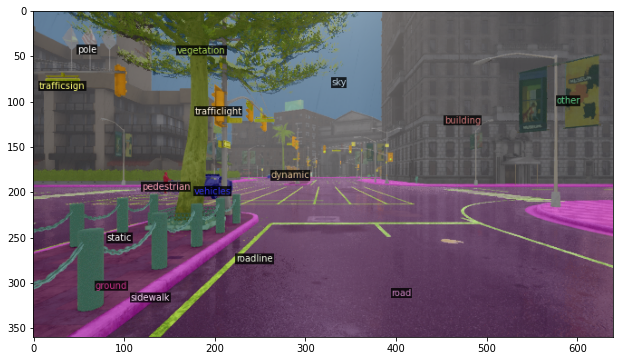

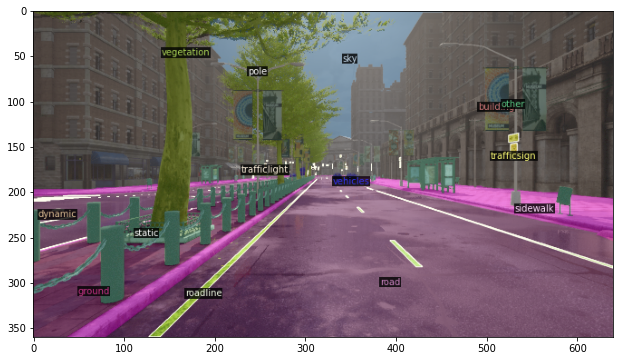

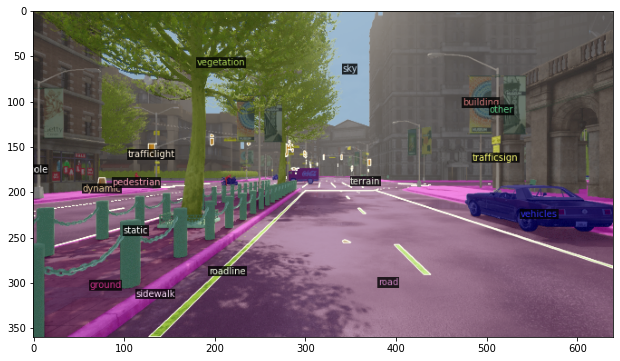

In [4]:
class Detectron2CustomDataset:
    carla_classes = ['unlabeled', 'building', 'fence', 'other', 'pedestrian', 'pole', 'roadline', 'road', 'sidewalk', 'vegetation', 'vehicles', 'wall', 'trafficsign', 'sky', 'ground', 'bridge', 'railtrack', 'guardrail', 'trafficlight', 'static', 'dynamic', 'water', 'terrain']
    carla_colors = [(0, 0, 0), (70, 70, 70), (100, 40, 40), (55, 90, 80), (220, 20, 60), (153, 153, 153), (157, 234, 50), (128, 64, 128), (244, 35, 232), (107, 142, 35), (0, 0, 142), (102, 102, 156), (220, 220, 0), (70, 130, 180), (81, 0, 81), (150, 100, 100), (230, 150, 140), (180, 165, 180), (250, 170, 30), (110, 190, 160), (170, 120, 50), (45, 60, 150), (145, 170, 100)]

    def __init__(self, train_dataset_name, val_dataset_name, get_train_dicts_fn, get_val_dicts_fn, classes=None, colors=None, ignore_label=0):
        
        if classes is None:
            self.classes = self.carla_classes
        if colors is None:
            self.colors = self.carla_colors
        print(f'Number of classes: {len(self.classes)}')
        
        self.train_dataset_name = train_dataset_name
        self.val_dataset_name = val_dataset_name
        
        self.get_train_dicts_fn = get_train_dicts_fn
        self.get_val_dicts_fn = get_val_dicts_fn
        
        DatasetCatalog.register(self.train_dataset_name, self.get_train_dicts_fn)
        DatasetCatalog.register(self.val_dataset_name, self.get_val_dicts_fn)

        MetadataCatalog.get(self.train_dataset_name).stuff_classes = self.classes
        MetadataCatalog.get(self.train_dataset_name).stuff_colors = self.colors
        MetadataCatalog.get(self.train_dataset_name).ignore_label = 0

        MetadataCatalog.get(self.val_dataset_name).stuff_classes = self.classes
        MetadataCatalog.get(self.val_dataset_name).stuff_colors = self.colors
        MetadataCatalog.get(self.val_dataset_name).ignore_label = ignore_label
        
    def visualize_train_dataset(self, num_samples=1):
        train_metadata = MetadataCatalog.get(self.train_dataset_name)
        data_train_dicts = self.get_train_dicts_fn()

        for file_dict in random.sample(data_train_dicts, num_samples):
            image = cv2.imread(file_dict['file_name'])
            visualizer = Visualizer(image[:, :, ::-1], metadata=train_metadata, scale=0.5)
            
            output = visualizer.draw_dataset_dict(file_dict)
            
            image = cv2.cvtColor(output.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)
            imshow_jupyter(image)

    def visualize_val_dataset(self, predictor, num_samples=1):
        val_metadata = MetadataCatalog.get(self.val_dataset_name)
        data_val_dicts = self.get_val_dicts_fn()

        for file_dict in random.sample(data_val_dicts, num_samples):
            image = cv2.imread(file_dict['file_name'])
            visualizer = Visualizer(image[:, :, ::-1], metadata=val_metadata, scale=0.5)
            
            print('Ground truth')
            output = visualizer.draw_dataset_dict(file_dict)
            target_image = cv2.cvtColor(output.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)
            imshow_jupyter(target_image)
            
            print('Predicted')
            outputs = predictor(image)
            sem_seg = torch.argmax(outputs['sem_seg'], dim=0)
            output = visualizer.draw_sem_seg(sem_seg.to('cpu'))
            predicted_image = cv2.cvtColor(output.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)
            imshow_jupyter(predicted_image)
            
            print()
            
carla_dataset = Detectron2CustomDataset('carla_train', 'carla_val',
                                        get_carla_train_dicts, get_carla_val_dicts)
carla_dataset.visualize_train_dataset(num_samples=1)

In [5]:
class Detectron2Trainer:
    def __init__(self, train_dataset_name, val_dataset_name):
        
        config_path = 'configs/Misc/semantic_R_50_FPN_1x.yaml'
        # model_path = 'https://dl.fbaipublicfiles.com/detectron2/ImageNetPretrained/MSRA/R-50.pkl'

        # All configs: https://detectron2.readthedocs.io/en/latest/modules/config.html
        
        self.train_dataset_name = train_dataset_name
        self.val_dataset_name = val_dataset_name

        self.cfg = get_cfg()
        self.cfg.merge_from_file(config_path)

        # self.cfg.MODEL.WEIGHTS = model_path
        self.cfg.MODEL.DEVICE = 'cuda'
        # self.cfg.MODEL.DEVICE = 'cpu'

        self.cfg.DATASETS.TRAIN = (self.train_dataset_name,)
        self.cfg.DATASETS.TEST = (self.val_dataset_name,)

        self.cfg.DATALOADER.NUM_WORKERS = 4

        # Number of images per batch across all machines. This is also the number
        # of training images per step (i.e. per iteration).
        self.cfg.SOLVER.IMS_PER_BATCH = 1
        self.cfg.SOLVER.BASE_LR = 0.01
        self.cfg.SOLVER.MAX_ITER = 1000
        self.cfg.SOLVER.GAMMA = 0.1
        # The iteration number to decrease learning rate by GAMMA.
        self.cfg.SOLVER.STEPS = (300, 600)
        # Save a checkpoint after every this number of iterations
        self.cfg.SOLVER.CHECKPOINT_PERIOD = 200

        self.cfg.MODEL.SEM_SEG_HEAD.IGNORE_VALUE = 0
        classes = MetadataCatalog.get(self.train_dataset_name).stuff_classes
        self.cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = len(classes)
        
        # Directory where output files are written
        self.cfg.OUTPUT_DIR = './output'
        
        os.makedirs(self.cfg.OUTPUT_DIR, exist_ok=True)
        self.trainer = DefaultTrainer(self.cfg)
        
        self.evaluator = SemSegEvaluator(self.val_dataset_name, output_dir=self.cfg.OUTPUT_DIR)
        
        self.trainer.register_hooks([hooks.EvalHook(0, lambda: self.trainer.test(self.cfg, self.trainer.model, self.evaluator))])
        
        self.predictor = None
        
    def load(self):
        self.trainer.resume_or_load(resume=True)
        
    def train(self):
        self.trainer.train()
        
    def get_predictor(self):
        last_checkpoint = 'model_final.pth'
        with open(os.path.join(self.cfg.OUTPUT_DIR, 'last_checkpoint')) as file:
            last_checkpoint = file.read()
        print('Last checkpoint: ' + last_checkpoint)
            
        self.cfg.MODEL.WEIGHTS = os.path.join(self.cfg.OUTPUT_DIR, last_checkpoint)
        self.predictor = DefaultPredictor(self.cfg)
        
    def test(self):
        self.get_predictor()
        self.trainer.test(self.cfg, self.predictor.model, self.evaluator)

trainer = Detectron2Trainer('carla_train', 'carla_val')

[04/02 18:30:43 d2.engine.defaults]: Model:
SemanticSegmentor(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (r

In [6]:
trainer.load()
trainer.train()

In [7]:
# # Look at training curves in tensorboard:
# %load_ext tensorboard
# %tensorboard --logdir output

In [8]:
trainer.test()

Last checkpoint: model_final.pth
[04/02 18:30:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/02 18:30:47 d2.data.common]: Serializing 31 elements to byte tensors and concatenating them all ...
[04/02 18:30:47 d2.data.common]: Serialized dataset takes 0.01 MiB
[04/02 18:30:47 d2.evaluation.evaluator]: Start inference on 31 batches
[04/02 18:31:00 d2.evaluation.evaluator]: Inference done 11/31. Dataloading: 0.0043 s/iter. Inference: 0.8999 s/iter. Eval: 0.1373 s/iter. Total: 1.0415 s/iter. ETA=0:00:20
[04/02 18:31:05 d2.evaluation.evaluator]: Inference done 16/31. Dataloading: 0.0048 s/iter. Inference: 0.8979 s/iter. Eval: 0.1323 s/iter. Total: 1.0353 s/iter. ETA=0:00:15
[04/02 18:31:11 d2.evaluation.evaluator]: Inference done 22/31. Dataloading: 0.0047 s/iter. Inference: 0.8939 s/iter. Eval: 0.1191 s/iter. Total: 1.0179 s/iter. ETA=0:00:09
[04/02 18:31:16 d2.evaluat

Last checkpoint: model_final.pth
Ground truth


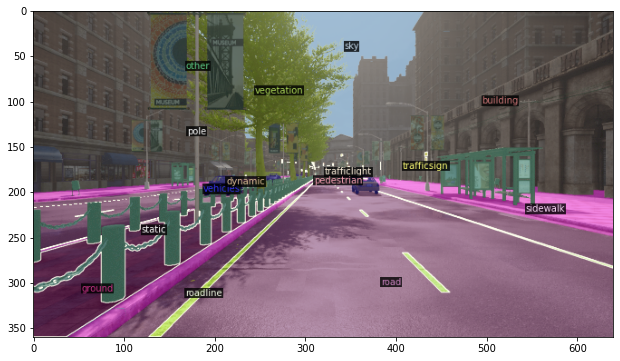

Predicted


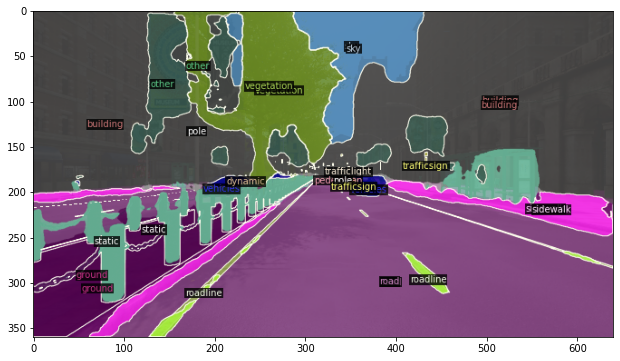

Ground truth


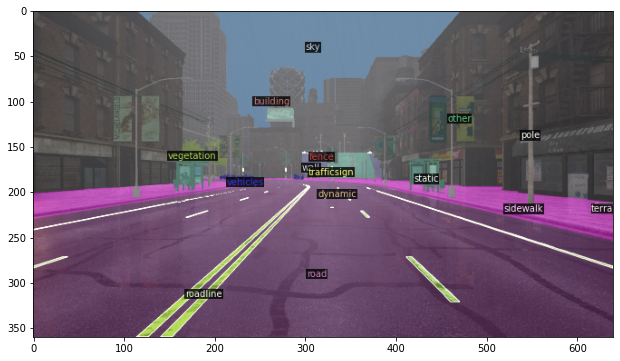

Predicted


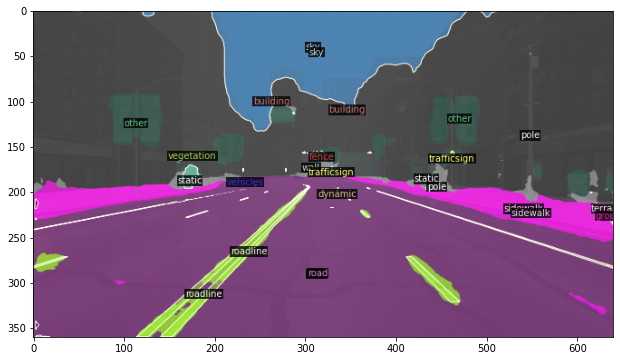

Ground truth


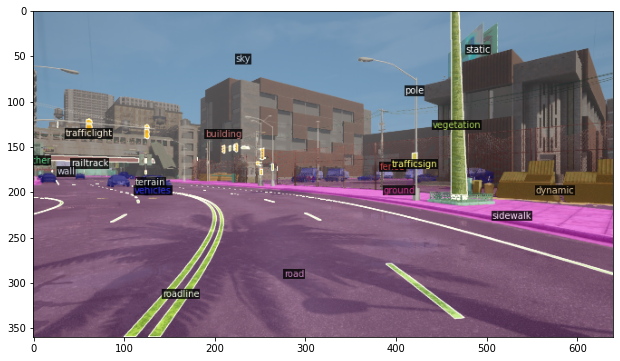

Predicted


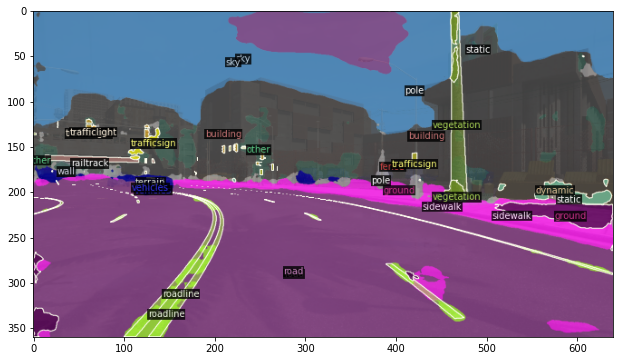

Ground truth


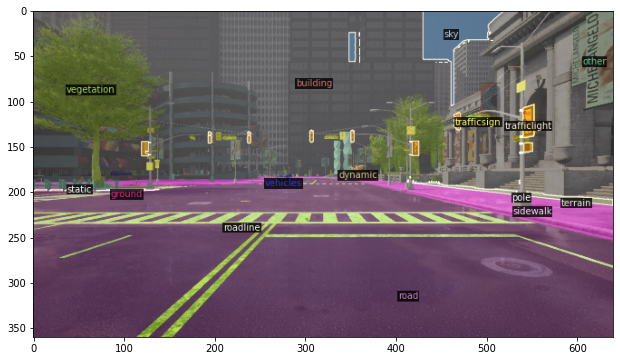

Predicted


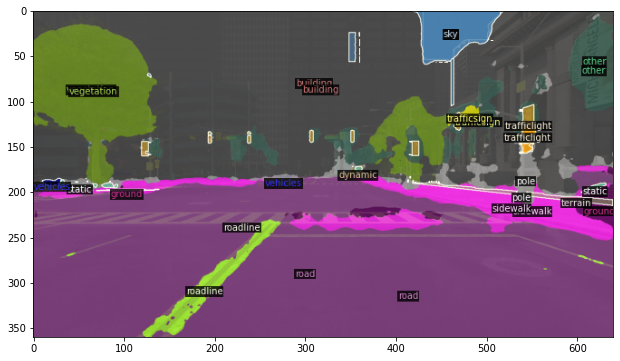

Ground truth


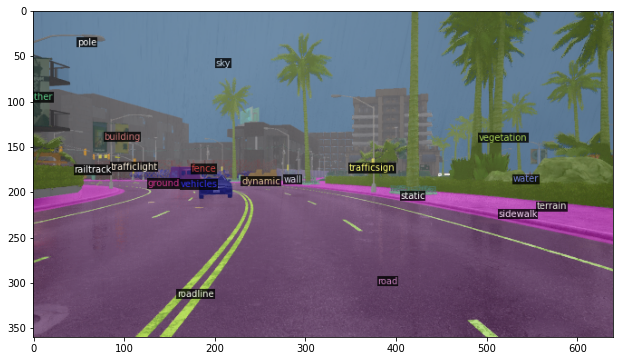

Predicted


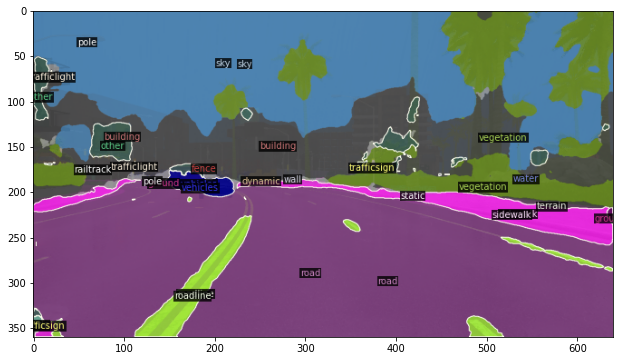

In [9]:
trainer.get_predictor()
carla_dataset.visualize_val_dataset(trainer.predictor, num_samples=5)